In [97]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy import integrate, optimize

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy import integrate, optimize

H_o     = 70.0 * (u.km / u.s) / u.Mpc
omega_b = 0.0463
omega_c = 0.233
omega_v = 0.721
omega_r = 1.0E-4
omega_m = omega_c + omega_b
omega   = omega_m + omega_v + omega_r


def H(a):
    _H = H_o * np.sqrt((omega_v + omega_m*a**(-3) + omega_r*a**(-4) -\
                   (omega - 1.0)*a**(-2)))
    return _H.to(u.km/u.s/u.Mpc)
    

def rho_crit(z):
    a = 1.0 / (1.0 + z)
    rho_c = 3.0 * (H(a))**2 / (8.0 * np.pi * const.G)
    rho_c = rho_c.decompose(bases=u.cgs.bases)
    return rho_c.to(u.g/u.cm**(3))

class halo:
    
    def __init__(self, vmax, sigma, f_b, z, T, mu, r_gas = None):
        
        self._vmax      = vmax
        self._sigma     = sigma
        self._f_b       = f_b
        self._z         = z
        self._T         = T
        self._mu        = mu
        self._r_gas     = r_gas

        
        if not hasattr(self._vmax, 'unit'):
            # assume cgs
            self._vmax = self._vmax * u.cm / u.s
            
        if not hasattr(self._T, 'unit'):
            self._T = self._T * u.K
            
        if not hasattr(self._r_gas, 'unit') and not self._r_gas == None:
            self._r_gas = self._r_gas * u.cm
        
        self._set_properties()
        
        return
    
    def potential(self, X):
        if hasattr(X,'unit'):
            X = X.decompose(bases=u.cgs.bases)
            if X.unit == u.cm:
                X = X / self.r_s
                X = X.decompose()
            
            X = X.value        
            
        X = np.asarray(X)
        scalar = False
        if X.ndim == 0:
            X = X[None]
            scalar = True
        
        pot = np.zeros(np.size(X)) * (self.vmax.unit)**2
        small_number = 1.0E-16
        pot[X <= small_number] = -75.0 / 32.0 * self.vmax**2 * (np.pi / 2.0)
        x   = X[X > small_number]
        pot[X>small_number] = -75.0 / 32.0 * self.vmax**2 *\
                        ((1.0/x)*(0.5*np.log(1+x**2)+np.log(1+x)-np.arctan(x)) +\
                         np.log(1+x)-0.5*np.log(1+x**2)-np.arctan(x)+np.pi/2.0)
        
        pot = pot.decompose(bases=u.cgs.bases)
        if scalar:
            return np.squeeze(pot)
        else:
            return pot
        
    def mass(self, x):
        if hasattr(x, 'unit'):
            x = x.decompose(bases=u.cgs.bases)
            
            if x.unit == u.cm:
                x = x / self.r_s
                x = x.decompose()
            
            x = x.value
            
        M = 1.5 * self.M_ds * (0.5*np.log(1.0+x**2)+np.log(1.0+x)-np.arctan(x))
        
        return M.decompose(bases=u.cgs.bases)
    
    def gas_density(self, x):
        if hasattr(x, 'unit'):
            x = x.decompose(bases=u.cgs.bases)
            
            if x.unit == u.cm:
                x = x / self.r_s
                x = x.decompose()
                
        return self.rho_s_gas * np.exp(-((self._mu*const.m_p)/(const.k_B*self._T)).decompose() * self.potential(x))
    
    def gas_pressure(self, x):
        if hasattr(x, 'unit'):
            x = x.decompose(bases=u.cgs.bases)
            
            if x.unit == u.cm:
                x = x / self.r_s
                x = x.decompose()
                
        return (self.gas_density(x) / (self._mu * const.m_p) * const.k_B * self._T).decompose(bases=u.cgs.bases)
    
    def _set_properties(self):
        # computes M_vir, R_vir
        def func(x):
            val = self.mass(x) / (4.0 * np.pi * (x*self.r_s)**3 /3.0)
            val = (val.to(u.g/u.cm**3)).value
            
            return (200.0*((rho_crit(self._z)).to(u.g/u.cm**3)).value)\
                   - val
        
        self.R_vir = self.r_s * optimize.brentq(func, 0.01, 100.0)
        self.M_vir = self.mass(self.R_vir / self.r_s)
        
        func  = lambda x : x*x *np.exp(((-self._mu*const.m_p)/(const.k_B*self._T)).decompose()*self.potential(x))
        
        if self._r_gas == None:
            self._r_gas = self.r_s
        
        rmax = np.logspace(np.log10((self._r_gas/self.r_s).decompose().value)  - 6,
                              np.log10((self._r_gas/self.r_s).decompose().value), 50.0)
        denom = 0.0
        for i in np.arange(1, np.size(rmax)):
            denom += integrate.quad(func, rmax[i-1], rmax[i])[0]
            
        
        denom = denom * 4.0 * np.pi * self.r_s**3
        self.rho_s_gas = self._f_b * self.M_vir / denom
        
        self.rho_s_gas = self.rho_s_gas.to(u.g/u.cm**3)
    
        return 
                                  
    @property
    def mu(self):
        return self._mu
    @mu.setter
    def mu(self,value):
        self._mu = value
        self._set_properties()
        return
            
                                  
    @property
    def M_gas(self):
        return self.M_vir * self._f_b
    
    @property
    def r_s(self):
        
        r_s = (210.0 * u.pc) * (self.v_s/(1.0E6*u.cm/u.s))**(1.39) *\
                      10.0**(-0.18*self.sigma)
        r_s = r_s.decompose(bases=u.cgs.bases)
        
        return r_s.to(u.cm)
    
    @property
    def v_s(self):
        return self._vmax / 0.8
    
    @property
    def rho_s(self):
        amu = 1.66E-24 * u.g / u.cm**3
        
        rho_s = 5.4 * amu * (self.v_s/(1.0E6*u.cm/u.s))**(-0.78)*\
                     10.0**(0.36*self.sigma)
        rho_s.decompose(bases=u.cgs.bases)
        
        return rho_s.to(u.g / u.cm**3)
    
    @property
    def M_ds(self):
        M_ds = 4.0 * np.pi * self.rho_s * self.r_s**3 / 3.0
        M_ds = M_ds.decompose(bases=u.cgs.bases)
        return M_ds.to(u.g)
    
    @property
    def vmax(self):
        return self._vmax
    
    @vmax.setter
    def vmax(self,value):
        self._vmax = value
        self._set_properties()
        return
    
    @property
    def f_b(self):
        return self._f_b
    
    @f_b.setter
    def f_b(self,value):
        self._f_b = value
        self._set_properties()
        return
    
    @property
    def sigma(self):
        return self._sigma
    
    @sigma.setter
    def sigma(self,value):
        self._sigma = value
        self._set_properites()
        return
    
    def print_properties(self):
        print "r_s   = %.4E pc"%(self.r_s.to(u.pc).value)
        print "v_c   = %.1f km/s"%(self._vmax.to(u.km/u.s).value)
        print "f_b   = %.3f"%(self._f_b)
        print "T     = %.4E K"%(self._T.value)
        print "M_gas = %.4E Msun"%(self.M_gas.to(u.Msun).value)
        print "M_vir = %.4E Msun"%(self.M_vir.to(u.Msun).value)
        print "R_vir = %.4E kpc"%(self.R_vir.to(u.kpc).value)
        rho_s_gas = self.rho_s_gas.to(u.g/u.cm**3)
        n_s_gas   = (rho_s_gas / (self._mu * const.m_p)).decompose(bases=u.cgs.bases)
        print "rho_s_gas = %.2E cgs    n_s_gas = %.2E cgs"%(rho_s_gas.value, n_s_gas.value)
        rho_o_gas = self.gas_density(0.0).to(u.g/u.cm**3)
        n_o_gas   = (rho_o_gas / (self._mu * const.m_p)).decompose(bases=u.cgs.bases)
        print "rho_o_gas = %.2E cgs    n_o_gas =  %.2E cgs"%(rho_o_gas.value, n_o_gas.value)
        
        
    def thermal_gradient(self, x, dx = None):
        if hasattr(x, 'unit'):
            x = x.decompose(bases=u.cgs.bases)
                
            if x.unit == u.cm:
                x = x / self.r_s
                x = x.decompose()
                
        if not dx == None: 
            if hasattr(dx, 'unit'):
                dx = dx.decompose(bases=u.cgs.bases)
              
                if dx.unit == u.cm:
                    dx = dx / self.r_s
                    dx = dx.decompose()
        else:
            dx = 1.0E-3 * x
            
        if np.size(x) > 1:            
            gas_density  = self.gas_density(x[1:])
            gas_pressure = self.gas_pressure(x)
            
            dPdr         = np.diff(gas_pressure) / np.diff(x)
            
        else:
            gas_density  = self.gas_density(x)
            dP           = self.gas_pressure(x+dx) - self.gas_pressure(x) 
            dPdr         = dP / dx
        
        result = dPdr / gas_density / self.r_s
        
        result = result.decompose(bases=u.cgs.bases)
        
        return result
    
    def acceleration(self, x, dx = None):
        if hasattr(x, 'unit'):
            x = x.decompose(bases=u.cgs.bases)
                
            if x.unit == u.cm:
                x = x / self.r_s
                x = x.decompose()
                
        if not dx == None: 
            if hasattr(dx, 'unit'):
                dx = dx.decompose(bases=u.cgs.bases)
                
                if dx.unit == u.cm:
                    dx = dx / self.r_s
                    dx = dx.decompose()
        else:
            dx = 1.0E-3 * x
            
        if np.size(x) > 1:
            dPhidr = np.diff( self.potential(x)) / np.diff(x)
            
        else:
            dPhidr = (self.potential(x+dx) - self.potential(x)) / dx
        
        dPhidr = dPhidr / self.r_s
        dPhidr = dPhidr.decompose(bases=u.cgs.bases)
        
        return dPhidr

In [117]:
h = halo(vmax = 200.0*u.km/u.s, sigma = 0.0, f_b = 0.002, z = 0.0, T = 1.0E4, mu = 1.1)

/home/emerick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:126: RuntimeWarning: overflow encountered in exp


In [118]:
h.print_properties()

r_s   = 1.8423E+04 pc
v_c   = 200.0 km/s
f_b   = 0.002
T     = 1.0000E+04 K
M_gas = 3.1384E+09 Msun
M_vir = 1.5692E+12 Msun
R_vir = 2.3973E+02 kpc
rho_s_gas = 0.00E+00 cgs    n_s_gas = 0.00E+00 cgs
rho_o_gas = NAN cgs    n_o_gas =  NAN cgs


/home/emerick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:103: RuntimeWarning: overflow encountered in exp


-4.18747850639e-09 cm / s2
4.19413443301e-09 cm / s2


/home/emerick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:103: RuntimeWarning: overflow encountered in exp


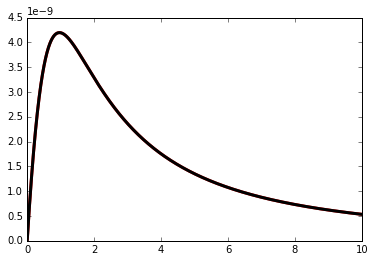

In [113]:
print h.thermal_gradient(1.0)
print h.acceleration(1.0)

x = np.linspace(0.0, 10.0, 100000)
plt.plot(x[1:],  -h.thermal_gradient(x).value, lw = 3, color = 'red')
plt.plot(x[1:],   h.acceleration(x).value, lw = 3, color = 'black')


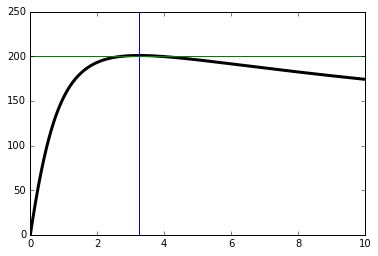

In [120]:
plt.plot(x[1:], np.sqrt(h.r_s*x[1:]*h.acceleration(x)).to(u.km/u.s).value, lw = 3, color = 'black')
plt.plot([3.25,3.25],plt.ylim())
plt.plot(plt.xlim(),[200.0,200.0])